# PBO learnt on several iterations and one weigth one the chain walk environment

## Define parameters

In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax

# keys
seed = 10
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
n_states = 10
n_actions = 2
n_repetitions = 10
sucess_probability = 0.9
gamma = 0.9

# Weights collection
n_weights = 1
filtering_weights = True

# Trainings
fitting_steps = 5
add_infinity = True

## Linear PBO
training_steps = 10
max_bellman_iterations = 200
batch_size_samples = n_states
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.001, "duration": 1}

## Q-learning
max_bellman_iterations_q = (max_bellman_iterations + int(add_infinity)) * training_steps
learning_rate_q = {"first": 0.001, "last": 0.001, "duration": 1}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [2]:
from pbo.environment.chain_walk import ChainWalkEnv

states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = (np.arange(n_states + 1 + 1) - 0.5)[:-1]
actions_boxes = (np.arange(n_actions + 1 + 1) - 0.5)[:-1]

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_states * n_actions * n_repetitions
replay_buffer = ReplayBuffer()

for state in states:
    for action in actions:
        # Need to repeat the samples to capture the randomness
        for _ in range(n_repetitions):
            env.reset(jnp.array([state]))
            next_state, reward, _, _ = env.step(jnp.array([action]))

            replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

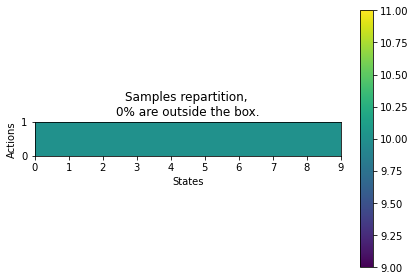

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, states_boxes, actions_boxes)
samples_visu_mesh = StateActionMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)

## Optimal Q function

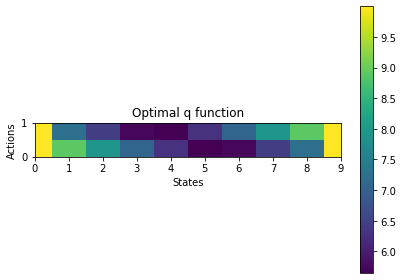

In [5]:
optimal_q = env.optimal_Q_mesh()

q_visu_mesh = StateActionMesh(states, actions, 0)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Train Q with Fitted-Q

In [6]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import TableQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=learning_rate_q,
    zero_initializer=True
)

training_losses_q = []
validation_losses_q = []

for _ in tqdm(range(max_bellman_iterations_q)):
    params_target = q.params

    for step in range(fitting_steps):
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, _ = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)        

    q_i = q.discretize(q.to_weights(params_target).reshape((-1, q.weights_dimension)), states, actions)[0]
    q_i_plus_1 = q.discretize(q.to_weights(q.params).reshape((-1, q.weights_dimension)), states, actions)[0]

    training_losses_q.append(jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean())
    validation_losses_q.append(jnp.abs(optimal_q - q_i_plus_1).mean())

  0%|          | 0/600 [00:00<?, ?it/s]

## Train PBO

In [19]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=learning_rate_q,
    zero_initializer=True
)
batch_weights = q.to_weights(q.params).reshape((1, -1))
pbo = LinearPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate)
importance_iteration = jnp.ones(max_bellman_iterations + 1)

training_losses = []
validation_losses = []

for _ in tqdm(range(training_steps)):
    params_target = pbo.params

    for _ in range(fitting_steps):
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            pbo.params, pbo.optimizer_state, _ = pbo.learn_on_batch(
                pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
            )


batch_iterated_weights = batch_weights.copy()
for _ in range(max_bellman_iterations_q):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]

    training_losses.append(jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean())
    validation_losses.append(jnp.abs(optimal_q - q_i_plus_1).mean())

  0%|          | 0/10 [00:00<?, ?it/s]

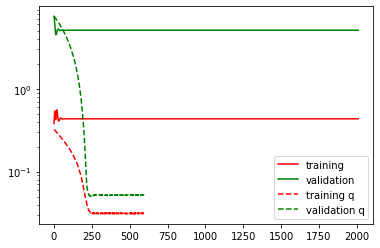

In [20]:
import matplotlib.pyplot as plt 

end = max_bellman_iterations_q

plt.plot(training_losses[:end], label="training", color="red")
plt.plot(validation_losses[:end], label="validation", color="green")
plt.plot(training_losses_q[:end], label="training q", color="red", linestyle="--")
plt.plot(validation_losses_q[:end], label="validation q", color="green", linestyle="--")

plt.yscale("log")
_ = plt.legend()

In [21]:
pbo.contracting_factor()

DeviceArray(4.9609847, dtype=float32)

In [22]:
np.linalg.norm(pbo.params["LinearPBONet/linear"]["w"], ord=1)

4.9609847